In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
library(ggplot2)

inputdir <- "./load_files/"
outputdir <- "./report/"


In [2]:
###----------------------------------------------------------------------------
## Organize the patterning center data from two species (mouse, rhesus)
RMFile <- paste0(inputdir, "PAT_RhesusMouse_data.Rdata")

if (!file.exists(RMFile)){
    ## Load Rhesus PAT data
    seu <- readRDS(file = paste0(inputdir, "PAT_inte.organizer.inte.rds"))
    sel_cls <- c("PC FGF17", "PC NKX2-1", "PC SFRP1", "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
    seu@meta.data$subclass <- gsub("PC NKX2-1.*", "PC NKX2-1", seu@meta.data$subtype)
    rpat <- subset(seu, subclass %in% sel_cls)


    ## Load Mouse PAT data
    ##mdev <- readRDS(file = paste0("/home/sm2726/project/public_data/mouse_dev_atlas_update/", 
    ##                              "mouse_pat_seurat_09172021.rds"))
    mdev <- readRDS(file = paste0(inputdir, "mouse_pat_seurat_09172021.rds"))
    mcls <- c("Anteromedial cerebral pole", "Hypothalamic floor-plate like", 
              "Cortical hem 1", "Cortical hem 2", 
              "Antihem 1", "Antihem 2", "Zona limitans intrathalamica")
    mpat <- subset(mdev, NewCluster %in% mcls)
    mpat@meta.data$subclass <- mpat@meta.data$NewCluster


    ## Create a new mouse seurat object with gene names in upper case
    mct <- mpat$RNA@counts
    rownames(mct) <- toupper(rownames(mct))
    aa <- seu_prepare(counts = mct, min.cells = 0, 
                      normalization.method = "LogNormalize", 
                      hvg.method = NULL, assay = "RNA")
    aa@meta.data <- mpat@meta.data[colnames(aa), setdiff(colnames(mpat@meta.data), colnames(aa@meta.data))]
    rm(mpat)
    mpat <- aa
    save(rpat, mpat, file = paste0(inputdir, "PAT_RhesusMouse_data.Rdata")) 
}
load(RMFile)
rpat
mpat

An object of class Seurat 
34619 features across 10100 samples within 1 assay 
Active assay: RNA (34619 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
31053 features across 1822 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)

In [3]:
## Calculate markers
MarFile <- paste0(inputdir, "PAT_RhesusMouse_markerRes.Rdata")
if (!file.exists(MarFile)) {
    Idents(rpat) <- "subclass"
    rhe_res <- FindAllMarkers(rpat, logfc.threshold = 0.2, min.pct = 0.1, only.pos = TRUE)

    Idents(mpat) <- "subclass"
    mou_res <- FindAllMarkers(mpat, logfc.threshold = 0.2, min.pct = 0.1, only.pos = TRUE)
    save(mou_res, rhe_res, file = paste0(inputdir, "PAT_RhesusMouse_markerRes.Rdata"))
}
load(MarFile)
head(mou_res)
head(rhe_res)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
NRG1,1.101760e-115,1.698267,0.902,0.223,3.421295e-111,Antihem 2,NRG1
PTPRZ1,2.346110e-109,1.481352,0.969,0.324,7.285376e-105,Antihem 2,PTPRZ1
CSMD1,3.712160e-103,1.540086,0.723,0.131,1.152737e-98,Antihem 2,CSMD1
CADM2,5.985956e-98,1.293842,0.812,0.200,1.858819e-93,Antihem 2,CADM2
RGCC,1.566954e-96,1.228021,0.902,0.251,4.865863e-92,Antihem 2,RGCC
CREB5,8.008561e-94,1.148597,0.839,0.233,2.486898e-89,Antihem 2,CREB5


,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
FRZB,0,1.5384490,0.373,0.024,0,PC NKX2-1,FRZB
NKX2-1,0,1.3320709,0.498,0.030,0,PC NKX2-1,NKX2-1
LMO1,0,1.2102657,0.457,0.079,0,PC NKX2-1,LMO1
MBIP,0,1.1019083,0.520,0.112,0,PC NKX2-1,MBIP
FOXG1,0,1.0344012,0.779,0.276,0,PC NKX2-1,FOXG1
NNAT,0,0.9411504,0.966,0.781,0,PC NKX2-1,NNAT


In [4]:
## Prepare the data for the visualization
load(file = paste0(inputdir, "PAT_RhesusMouse_data.Rdata")) ## rpat, mpat, 
load(file = paste0(inputdir, "PAT_RhesusMouse_markerRes.Rdata")) ## mou_res, rhe_res


rord <- c("PC FGF17", "PC NKX2-1", "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
mord <- c("Anteromedial cerebral pole", "Hypothalamic floor-plate like", 
          "Cortical hem 2", "Cortical hem 1", 
          "Antihem 1", "Antihem 2", "Zona limitans intrathalamica")

rlist <- list(RPC1 = c("PC FGF17"),
                RPC2 = "PC NKX2-1", 
                Hem = c("PC RSPO3", "PC TTR"),
                AntiHem = c("PC SFRP2"),
                ZLT = "PC TCF7L2")
mlist <- list(RPC1 = "Anteromedial cerebral pole",
                RPC2 = "Hypothalamic floor-plate like", 
                Hem = c("Cortical hem 2", "Cortical hem 1"),
                AntiHem = c("Antihem 1", "Antihem 2"),
                ZLT = "Zona limitans intrathalamica")

extract_mars <- function(res, fc = 1.2) {
    mm <- res %>%
        mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01)) %>%
        filter(ratio_fc >= fc) %>%
        group_by(cluster) %>%
        mutate(p_val_adj = p.adjust(p_val, method = "fdr")) %>%
        filter(p_val_adj <= 0.01) %>%
        arrange(desc(ratio_fc), .by_group = TRUE) %>%
        ungroup() 
    nn <- split(mm$gene, mm$cluster)
    nn
}
rhe_mars <- extract_mars(res = rhe_res, fc = 1.25) 
mou_mars <- extract_mars(res = mou_res, fc = 1.25)
lapply(rhe_mars, head, 20)
lapply(mou_mars, head, 20)

$`PC NKX2-1`
 [1] "NKX2-1"       "FRZB"         "NKX6-2"       "SPON1"        "SPARCL1"     
 [6] "FZD5"         "DLX2"         "LMO1"         "EDNRB"        "DLX1"        
[11] "OLIG2"        "MBIP"         "LOC106999377" "AMER2"        "FOXO1"       
[16] "VAX1"         "SLC10A4"      "SLC9A6"       "FGFBP3"       "ADGRV1"      

$`PC FGF17`
 [1] "FGF17"        "FGF18"        "FGF3"         "FGF8"         "LYN"         
 [6] "AGR3"         "ETV4"         "SMOC1"        "DUSP6"        "SP8"         
[11] "GALP"         "LOC715487"    "LOX"          "SPRY1"        "ISLR2"       
[16] "PCDH11X"      "TMEM132D"     "IL17RD"       "LOC114677713" "LOC114676270"

$`PC SFRP1`
 [1] "MEIS2"        "LOC114671890" "SFRP1"        "HOPX"         "LOC106993104"
 [6] "SALL1"        "POU3F3"       "DDAH1"        "GSX2"         "TSPAN7"      
[11] "EFNA5"        "GAP43"        "DLK1"         "GNG4"         "FZD8"        
[16] "LOC114670453" "HS6ST2"       "FOXG1"        "BCAT1"        "FAM181B"     

$`PC SFRP2`
 [1] "SFRP2"        "SNCA"         "C5H4orf45"    "VCAM1"        "LOC114679021"
 [6] "NTRK2"        "WNT7B"        "NCALD"        "PENK"         "HTRA1"       
[11] "PTX3"         "NR2F2"        "PAX6"         "DCUN1D4"      "COL11A1"     
[16] "FAM107A"      "CRYGD"        "LOC696885"    "SLF1"         "GSX2"        

$`PC RSPO3`
 [1] "RSPO2"        "SULT1E1"      "WNT2B"        "LOC716075"    "HEY2"        
 [6] "LOC106998157" "WNT8B"        "EFHD1"        "SULF2"        "LOC106998526"
[11] "FSTL5"        "LHX9"         "CALB1"        "B3GAT2"       "RSPO3"       
[16] "MASP1"        "TSHZ3"        "DMRT3"        "LOC114672103" "LOC114676364"

$`PC TTR`
 [1] "CLIC6"    "QRICH2"   "CA2"      "IGFBP7"   "RBM47"    "HTR2C"   
 [7] "SLC17A8"  "SNTG1"    "SLC38A11" "DKK2"     "COLEC12"  "SOSTDC1" 
[13] "CFAP126"  "CAPSL"    "CLDN19"   "SLC16A10" "MSX1"     "PIFO"    
[19] "SLC4A5"   "TMEM88"  

$`PC TCF7L2`
 [1] "NTS"          "WNT4"         "BARHL2"       "IRX3"         "SHOX2"       
 [6] "LOC106994320" "WNT3"         "TAL2"         "PDZRN4"       "LOC106999599"
[11] "FZD10"        "IRX5"         "IRX2"         "APCDD1"       "GRID2"       
[16] "NTNG1"        "PDIA5"        "TPD52"        "CRNDE"        "CMTM7"

$`Antihem 2`
 [1] "GM26604"  "BCAN"     "TNC"      "FSTL5"    "GRIK1"    "KCNJ10"  
 [7] "SLC6A11"  "ATP1A2"   "WNT7A"    "GM28175"  "GM29260"  "RLBP1"   
[13] "ADAMTS18" "SPARCL1"  "SCRG1"    "CSMD1"    "CSMD2"    "PAQR7"   
[19] "DLX1"     "GM44593" 

$`Antihem 1`
 [1] "ALDH1L1"       "GM29260"       "GM13889"       "MMD2"         
 [5] "QRFPR"         "GSX2"          "GRIN2B"        "1500009C09RIK"
 [9] "NWD1"          "EVA1C"         "HEPACAM"       "TNC"          
[13] "RLBP1"         "GPC5"          "SH3RF3"        "FSTL5"        
[17] "KCNH7"         "DAPP1"         "ACSBG1"        "GM28175"      

$`Cortical hem 2`
 [1] "RHCG"          "DCN"           "E330013P04RIK" "DMRT1"        
 [5] "EMX1"          "DMRTB1"        "DMRT3"         "NEUROG2"      
 [9] "FZD9"          "LMO2"          "SERTM1"        "RSPO3"        
[13] "WNT3A"         "DMRTA2OS"      "RSPO1"         "LRRC4C"       
[17] "SLC35G2"       "GALNT14"       "MSX2"          "WNT9A"        

$`Hypothalamic floor-plate like`
 [1] "GPR50"         "RAX"           "NKX2-9"        "NKX2-2"       
 [5] "TECRL"         "SHH"           "SIX6"          "POU3F1"       
 [9] "GM26709"       "4930447C04RIK" "NKX2-1"        "FNDC3C1"      
[13] "RAI2"          "CALB2"         "COL1A1"        "LRMDA"        
[17] "CNTN6"         "CRABP1"        "S100A10"       "MME"          

$`Zona limitans intrathalamica`
 [1] "BARHL2"        "NECAB1"        "PITX2"         "SIM2"         
 [5] "DBX1"          "BARHL1"        "DKK1"          "FOXB1"        
 [9] "TTC6"          "FST"           "B230323A14RIK" "FOXA2"        
[13] "GSC2"          "DKK2"          "NKX2-4"        "2700046A07RIK"
[17] "LMX1B"         "LYPD1"         "RBFOX3"        "POU3F4"       

$`Anteromedial cerebral pole`
 [1] "PAX5"    "IRS4"    "FGF17"   "FGF8"    "PAX2"    "FGF18"   "CYTL1"  
 [8] "FGF15"   "SP8"     "MYLK"    "FEZF1"   "DUSP9"   "SMOC1"   "IL17RD" 
[15] "SPRY1"   "EPOP"    "RASL11A" "STRA6"   "GALNT12" "GREB1"  

$`Cortical hem 1`
 [1] "RBM47"         "HTR2C"         "WFIKKN2"       "CALML4"       
 [5] "3100003L05RIK" "KCNE2"         "GMNC"          "COL8A2"       
 [9] "KCNJ13"        "AQP1"          "ZFP804B"       "TTR"          
[13] "MIA"           "CFAP126"       "FAM163A"       "SLC4A10"      
[17] "PTHLH"         "ATP2B3"        "FOLR1"         "1700016K19RIK"

In [5]:
####----------------------------------------------------------------------------
## Find species-conserved markers

## For each major domain, find the shared top 100 markers
conserved_genes <- lapply(names(rlist), function(gp) {
                rr <- rhe_mars[rlist[[gp]]] %>%
                        lapply(., function(x) x[1:min(100, length(x))]) %>% 
                           unlist() %>% 
                           unique()
                mm <- mou_mars[mlist[[gp]]] %>%
                        lapply(., function(x) x[1:min(100, length(x))]) %>% 
                           unlist() %>% 
                           unique()
                sh <- intersect(rr, toupper(mm))%>%
                    intersect(., rownames(rpat)) %>%
                    intersect(., rownames(mpat))
  return(sh)
}) %>%
  setNames(., names(rlist))
conserved_genes

$RPC1
 [1] "FGF17"   "FGF18"   "FGF8"    "ETV4"    "SMOC1"   "DUSP6"   "SP8"    
 [8] "SPRY1"   "IL17RD"  "ZIC4"    "GALNT12" "ZIC3"    "NR2F6"   "ZIC1"   
[15] "FEZF1"  

$RPC2
 [1] "NKX2-1" "NKX6-2" "SPON1"  "MBIP"   "CXXC4"  "DLK1"   "LRP2"   "EPHB1" 
 [9] "PTCH1"  "SIX3"   "TCF7L2" "IGFBP5"

$Hem
 [1] "RSPO2"     "WNT8B"     "RSPO3"     "MASP1"     "DMRT3"     "CADPS"    
 [7] "SP5"       "DMRTA2"    "RFX4"      "ARX"       "EMX1"      "DOK5"     
[13] "WLS"       "CACHD1"    "AXIN2"     "EMX2"      "DCC"       "RSPO1"    
[19] "RAB11FIP2" "IGSF21"    "NEUROG2"   "FEZF2"     "LEF1"      "PLEKHG1"  
[25] "BCL11B"    "CLIC6"     "RBM47"     "HTR2C"     "CFAP126"   "SLC16A10" 
[31] "MSX1"      "PIFO"      "SLC4A5"    "TTR"       "CACNA2D3"  "MITF"     
[37] "KCNJ13"    "CGNL1"     "GDF5"      "BMP4"      "KCTD8"     "JPH1"     

$AntiHem
[1] "PTX3"    "GSX2"    "S100A13" "POU3F2"  "LIMCH1"  "VEPH1"  

$ZLT
[1] "BARHL2" "TAL2"   "OTX1"   "FST"    "IGDCC3" "ZFHX3"

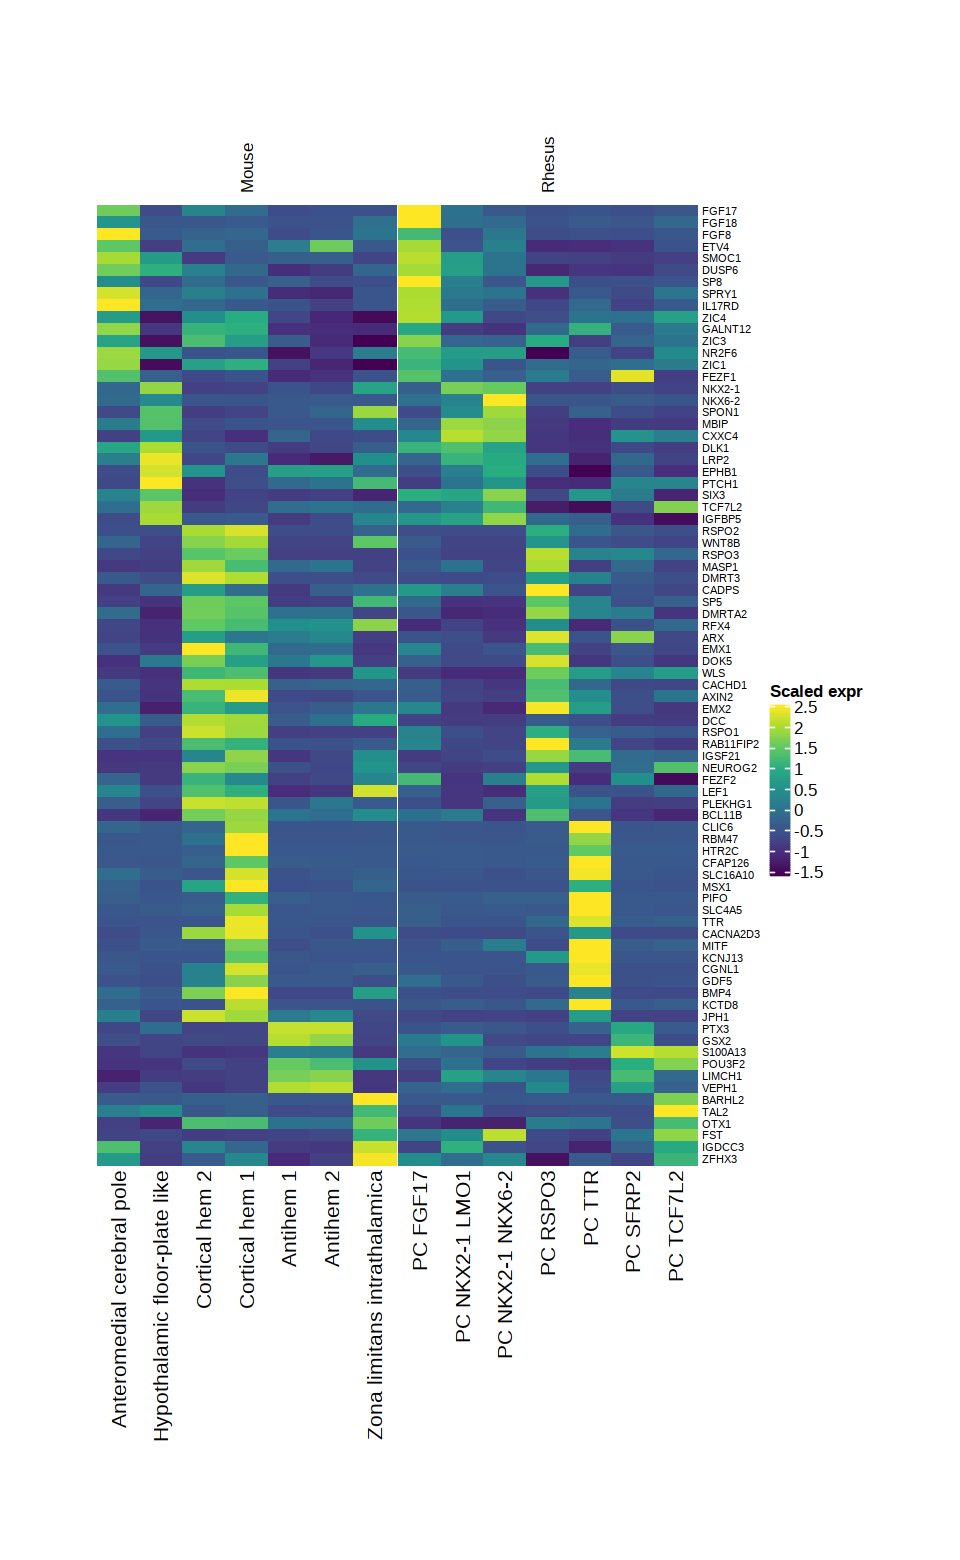

In [6]:
## Visualize the conserved markers on a heatmap
Idents(rpat) <- "subtype"
rhe_avgs <- log(AverageExpression(rpat, assay = "RNA", verbose = FALSE)$RNA + 1)
Idents(mpat) <- "subclass"
mou_avgs <- log(AverageExpression(mpat, assay = "RNA", verbose = FALSE)$RNA + 1)


gene_use <- unlist(conserved_genes) %>% unique()
data_use <- cbind(rhe_avgs[gene_use, c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", 
                                       "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")], 
                  mou_avgs[gene_use, mord]) %>%
                t() %>% scale() %>% t() %>%
                MinMax(., min = -2.5, max = 2.5)


## visualize in heatmap
legend_limits <- c(-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5)
color_breaks <- legend_limits[legend_limits >= min(data_use) & legend_limits <= max(data_use)]
htlist <- Heatmap(data_use, name = "Average Expression",  na_col = "lightgrey",
        cluster_columns = FALSE,
        column_split = rep(c("Rhesus", "Mouse"), c(7, 7)),
        cluster_rows = FALSE,
        show_column_dend = FALSE,
        cluster_column_slices = FALSE,
        column_title_gp = gpar(fontsize = 10),
        column_gap = unit(0.5, "mm"),
        show_row_dend = FALSE,
        col = colorRamp2(color_breaks, viridis::viridis(length(color_breaks))),
        row_names_gp = gpar(fontsize = 6),
        column_title_rot = 90,
        show_column_names = TRUE,
        use_raster = FALSE,
        heatmap_legend_param = list(title = "Scaled expr", color_bar = "continuous", at = color_breaks),
        width = unit(5, "in"),
        height = unit(8, "in"))
options(repr.plot.width=8, repr.plot.height=13)
draw(htlist)

In [7]:
pdf(paste0(outputdir, "PAT_RhesusMouse_conserved_exp.pdf"), width = 8, height = 10)
draw(htlist)
dev.off()

png 
  2

In [8]:
#-------------------------------------------------------------
## Find rhesus-enriched markers
all_genes <- intersect(rownames(rpat), toupper(rownames(mpat)))
exp_ratio <- lapply(c(rord, mord), function(x) {
  data <- if (grepl("PC ", x)) {rpat} else {mpat}
  subseu <- data[,  data@meta.data$subclass %in% x]
  ratio <- Matrix::rowMeans(subseu$RNA@data != 0)
  ratio <- ratio[all_genes]
  return(ratio)
}) %>%
      setNames(., c(rord, mord)) %>%
      as.data.frame(., check.names = FALSE) %>%
      as.matrix()
head(exp_ratio)
sum(is.na(exp_ratio))

,PC FGF17,PC NKX2-1,PC RSPO3,PC TTR,PC SFRP2,PC TCF7L2,Anteromedial cerebral pole,Hypothalamic floor-plate like,Cortical hem 2,Cortical hem 1,Antihem 1,Antihem 2,Zona limitans intrathalamica
SH3BP5L,0.025874461,0.02380952,0.025248344,0.043147208,0.01364024,0.01540154,0.1642651,0.1131498,0.1735537,0.123931624,0.1411290,0.1071429,0.1149425
LYPD8,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000
TRIM58,0.003833253,0.00000000,0.001241722,0.001269036,0.00000000,0.00220022,0.0000000,0.0000000,0.0000000,0.000000000,0.0000000,0.0000000,0.0000000
NLRP3,0.023957834,0.02380952,0.011175497,0.013959391,0.01619778,0.01650165,0.0000000,0.0000000,0.0000000,0.002136752,0.0000000,0.0000000,0.0000000
AHCTF1,0.062290369,0.06349206,0.063741722,0.086294416,0.05967604,0.03410341,0.3083573,0.1712538,0.1735537,0.194444444,0.2379032,0.2857143,0.2643678
SCCPDH,0.279348347,0.23068783,0.314983444,0.392131980,0.27280477,0.31243124,0.3602305,0.2966361,0.3471074,0.294871795,0.2540323,0.2500000,0.3678161


[1] 0

In [9]:
## Functions to identify species-specific markers
IdentifySpMarkers <- function(test_mars, bg_mars, test_list, bg_list, all_genes, exp_ratio){
    spec_genes <- lapply(names(test_list), function(gp) {
        test <- test_mars[test_list[[gp]]] %>%
                        lapply(., function(x) x[1:min(100, length(x))]) %>% 
                        unlist() %>% 
                        unique()
        bg <- bg_mars[bg_list[[gp]]] %>%
                        unlist() %>% 
                        unique()
        spec <- setdiff(test, toupper(bg))%>% ## setdiff(top 100 rhesus markers, all mouse markers)
                        intersect(., all_genes)

        ## ratio threshold
        idx1 <- lapply(test_list[[gp]], function(x) exp_ratio[spec, x] >= 0.2) %>%
                        Reduce("|", .)

        idx2 <- lapply(bg_list[[gp]], function(x) exp_ratio[spec, x] < 0.05) %>%
                        Reduce("&", .)
        print(sum(is.na(idx1)))
        print(sum(is.na(idx2)))
        spec <- spec[idx1 & idx2]
        return(spec)
    }) %>%
      setNames(., names(test_list))
    return(spec_genes)
}

In [10]:
## Functions for the dotplot
PlotRMDot <- function (rm_obj, mm_obj, rm_ord, mm_ord, features) {
    plist <- lapply(c("mouse", "macaque"), function(sp){
        object <- switch(sp, 
                        mouse = mm_obj, macaque = rm_obj)
        cls_ord <- switch(sp, 
                        mouse = mm_ord, macaque = rm_ord)
        Idents(object) <- "subclass"
        p <- DotPlot(object, features = features, dot.scale = 5, 
                      scale.by = "radius", cols = c("lightgrey", switch(sp, mouse = "blue", macaque = "red"))) +
                coord_flip() +
                RotatedAxis() +
                scale_y_discrete(limits = cls_ord) +
                scale_radius(range = c(0, 5), limits = c(0, 100)) +
                theme_bw() + 
                RotatedAxis() + 
                theme(legend.position = "bottom", 
                      axis.text.y = element_text(size = rel(0.6)), 
                      panel.grid = element_line(size = 0.2))
        
        if (sp %in% "macaque"){
            p <- p + 
                theme(axis.text.y = element_blank(), 
                      axis.title.y = element_blank(), 
                      axis.ticks.y = element_blank(), 
                      axis.line.y = element_blank(), 
                      panel.grid = element_line(size = 0.2))
        }
        return(p)
        })
    pcbn <- patchwork::wrap_plots(plist, nrow = 1, ncol = 2)
    return(pcbn)
}


[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0


$RPC1
[1] "GALP"  "LOX"   "ANXA2" "FKBP7" "CD200"

$RPC2
[1] "EDNRB"   "OLIG2"   "VAX1"    "OLIG1"   "FOXG1"   "FST"     "CAMK2N1"
[8] "SCHIP1" 

$Hem
 [1] "FSTL5"    "LHX9"     "NKAIN1"   "QRICH2"   "IGFBP7"   "SLC38A11"
 [7] "DKK2"     "CLDN19"   "SAMD11"   "LYPD1"    "CLDN5"    "TMEM200A"
[13] "CRABP1"   "OLFML3"   "LINGO1"   "SERPINF1" "OPCML"    "CHODL"   

$AntiHem
[1] "FEZF1"

$ZLT
[1] "NTS"     "WNT4"    "SHOX2"   "WNT3"    "APCDD1"  "NTNG1"   "KLHDC8A"
[8] "S100A13"

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

Warning message:
“Removed 32 rows containing missing values (geom_point).”


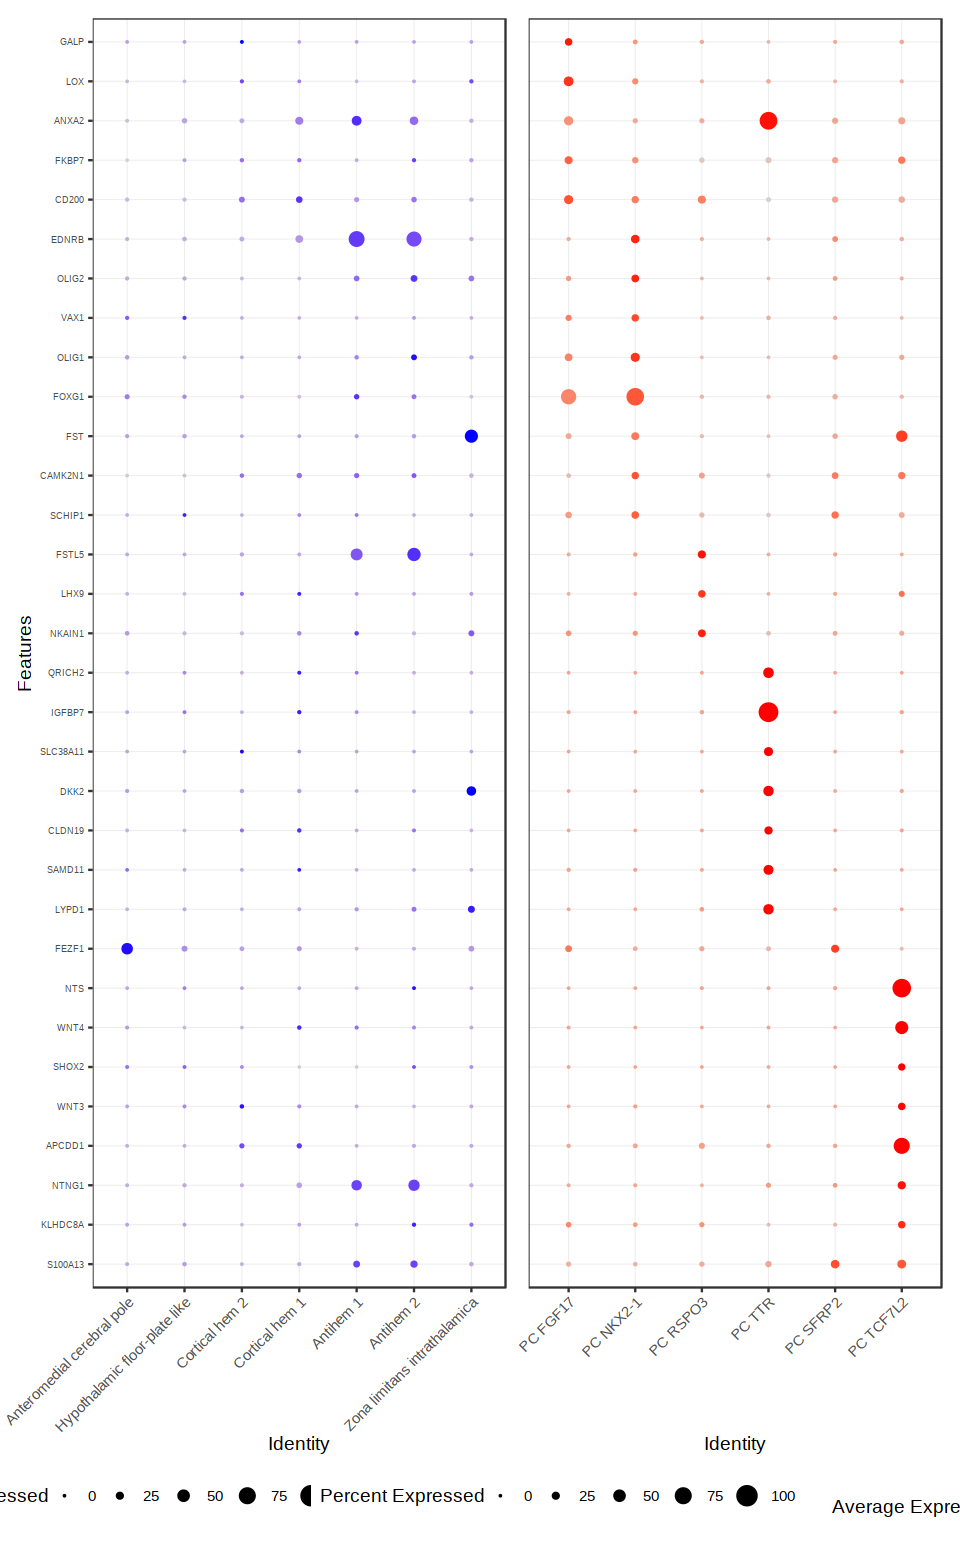

In [11]:
## Rhesus-specific markers
rhe_spec_all_genes <- IdentifySpMarkers(test_mars = rhe_mars, bg_mars = mou_mars, 
                                        test_list = rlist, bg_list = mlist, 
                                        all_genes = all_genes, exp_ratio = exp_ratio)
rhe_spec_all_genes
rhe_spec_vis_genes <- rhe_spec_all_genes %>%
                        lapply(., function(x) x[1:min(10, length(x))]) %>%
                        unlist() %>% 
                        unique()
p_macaque <- PlotRMDot(rm_obj = rpat, mm_obj = mpat, rm_ord = rord, mm_ord = mord, features = rhe_spec_vis_genes)
p_macaque

In [12]:
pdf(paste0(outputdir, "PAT_RM_macaque_specific_markers_top10.pdf"), width = 6, height = 7, useDingbats = FALSE)
print(p_macaque)
dev.off()

Warning message:
“Removed 32 rows containing missing values (geom_point).”


png 
  2

[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0


$RPC1
 [1] "PAX5"    "IRS4"    "MYLK"    "DUSP9"   "EPOP"    "RASL11A" "STRA6"  
 [8] "DUSP5"   "SCUBE1"  "DNMT3B"  "SLC2A3"  "PTPRM"   "CDH20"   "SLC16A3"
[15] "PTGIS"   "CCNE1"   "SLC1A5"  "TFAP4"   "SHISA2"  "FBXW4"   "GBE1"   
[22] "CDC6"    "AUNIP"   "SDC1"    "ASNS"    "LIN28B"  "EXOSC2"  "CDCA7L" 
[29] "PCGF6"   "GRWD1"   "BOK"     "PRKCA"   "TPD52"   "SHMT1"   "KCNQ5"  
[36] "MAST4"   "CMTM7"   "KIRREL3" "WDR4"    "MYBBP1A" "EPHA7"  

$RPC2
 [1] "RAX"     "NKX2-2"  "SIX6"    "POU3F1"  "RAI2"    "LRMDA"   "CNTN6"  
 [8] "CRABP1"  "MME"     "TOX2"    "SELENOP" "CLSTN2"  "NEBL"    "CNN2"   
[15] "DACH2"   "KCNH2"   "MYO16"   "MXRA8"   "ARID3A"  "LAMA1"   "MAF"    
[22] "TMTC2"   "LIN28A"  "CPNE5"   "TUBB6"   "ROBO1"   "TIMP3"   "FBN2"   
[29] "CCDC160" "HSD11B2" "PCSK5"   "LIN28B"  "PDZRN3"  "CDH6"    "TPM2"   
[36] "TMEM37"  "SCUBE1"  "LPAR1"   "DNAJC12"

$Hem
 [1] "RHCG"     "DCN"      "FZD9"     "SLC35G2"  "GALNT14"  "MSX2"    
 [7] "WNT9A"    "PLPPR1"   "EDIL3"    "KHDRBS2"  "RHBDL3"   "CASZ1"   
[13] "UNC5C"    "ST3GAL6"  "FUT9"     "BMP5"     "LRRTM3"   "CACNG4"  
[19] "PCP4L1"   "TMEM176B" "CALML4"   "GMNC"     "PTHLH"    "ADAMTS5" 
[25] "RASGEF1B" "HSPB8"    "ROR1"     "ASIC2"    "CLMN"     "FLRT1"   
[31] "LRP1B"    "SLC6A15" 

$AntiHem
 [1] "ALDH1L1"    "MMD2"       "GRIN2B"     "EVA1C"      "HEPACAM"   
 [6] "TNC"        "RLBP1"      "SH3RF3"     "FSTL5"      "KCNH7"     
[11] "ACSBG1"     "ATP1A2"     "PCDH8"      "TTC9B"      "LMCD1"     
[16] "SLC6A11"    "S1PR1"      "LIPG"       "SYBU"       "ACSS1"     
[21] "VIT"        "CSMD1"      "TNFAIP6"    "DLX2"       "ALDOC"     
[26] "INPP4B"     "UNC5D"      "CSDC2"      "ACTR3B"     "TMEM132B"  
[31] "TNFAIP8L1"  "ADAMTS18"   "PIF1"       "NRG1"       "WNT7A"     
[36] "RORB"       "PAQR8"      "KCND3"      "HS3ST1"     "SLC15A2"   
[41] "ST6GALNAC5" "CSMD2"      "PDE1B"      "PMP22"      "IGSF11"    
[46] "EMP1"       "CSPG5"      "KLF15"      "MLC1"       "MT3"       
[51] "ZFPM2"      "S100A1"     "NDRG2"      "PAG1"       "RNF180"    
[56] "SLC1A2"     "SPARCL1"    "AKAP6"      "SNCAIP"     "KIF14"     
[61] "BCAN"       "GRIK1"      "GRIA2"      "NRXN3"      "SLC6A1"    
[66] "SLCO1C1"    "S100A16"    "IL18"       "SGCD"       "EEPD1"     
[71] "DUSP10"     "CREB5"      "DNER"       "MEGF10"     "SHC3"      
[76] "KCND2"      "HECTD2"     "EPHA5"      "CAVIN3"    

$ZLT
 [1] "NECAB1"   "PITX2"    "SIM2"     "DBX1"     "BARHL1"   "DKK1"    
 [7] "FOXA2"    "DKK2"     "NKX2-4"   "LMX1B"    "RBFOX3"   "POU3F4"  
[13] "CFAP77"   "THSD7A"   "SPON1"    "ABCD2"    "SHH"      "GREB1L"  
[19] "NKX2-1"   "CDH8"     "SMYD2"    "LHX5"     "NTN1"     "ELMO1"   
[25] "CHN2"     "LMO1"     "WNT8B"    "EPHA7"    "ELOVL4"   "ZBTB16"  
[31] "FKBP11"   "SCUBE1"   "ARHGAP10" "PDLIM1"   "LIN28B"   "EPHA3"   
[37] "FOXP2"    "SLC16A3"  "SFMBT1"   "PRKG1"    "SDC1"     "UTP4"    
[43] "PRTG"

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

Warning message:
“Removed 50 rows containing missing values (geom_point).”


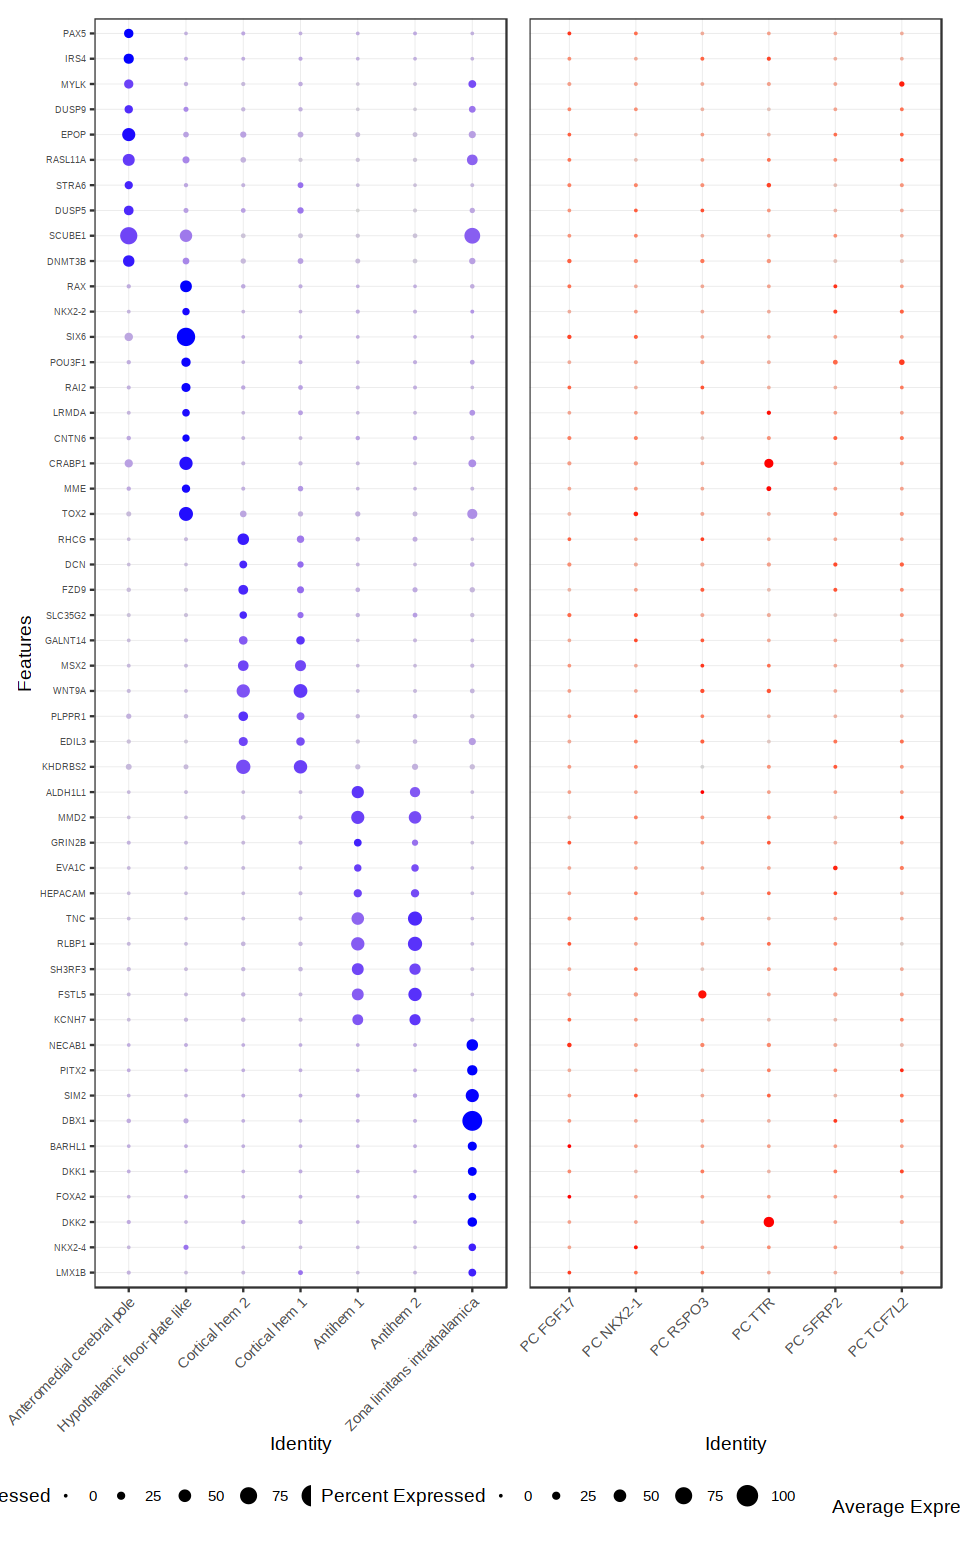

In [13]:
## Mouse-specific markers
mou_spec_all_genes <- IdentifySpMarkers(test_mars = mou_mars, bg_mars = rhe_mars, 
                                        test_list = mlist, bg_list = rlist, 
                                        all_genes = all_genes, exp_ratio = exp_ratio)
mou_spec_all_genes
mou_spec_vis_genes <- mou_spec_all_genes %>%
                        lapply(., function(x) x[1:min(10, length(x))]) %>%
                        unlist() %>% 
                        unique()
p_mouse <- PlotRMDot(rm_obj = rpat, mm_obj = mpat, rm_ord = rord, mm_ord = mord, features = mou_spec_vis_genes)
p_mouse

In [14]:
pdf(paste0(outputdir, "PAT_RM_mouse_specific_markers_top10.pdf"), width = 6, height = 7, useDingbats = FALSE)
print(p_mouse)
dev.off()

Warning message:
“Removed 50 rows containing missing values (geom_point).”


png 
  2

In [15]:
save(mou_spec_all_genes, mou_spec_vis_genes, 
     rhe_spec_all_genes, rhe_spec_vis_genes, file = "./load_files/PAT_RM_species_specific_markers.rds")


In [16]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggplot2_3.3.0        circlize_0.4.13      ComplexHeatmap_2.2.0
[4] dplyr_1.0.7          Seurat_3.1.5        

loaded via a namespace (and not attached):
 [1] nlme_3.1-147   